# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [343]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        if len(weights) > X.shape[1]:
            return 1/(1 + np.exp(0 - np.dot(X, weights[1:]) + weights[0]))
        else:
            return 1/(1 + np.exp(0 - np.dot(X, weights)))
    
    
    def get_sigmoid_gr(self, X, weights, y):
        """Compute the sigmoid value."""
        # <your code>
        return 1/(1 + np.exp((0 - (np.dot(X, weights))) * y))
    
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        summ = 0
        for i in range(len(y)):
            summ += np.log(1 + np.exp((0 - (np.dot(x[i], weights[1:]) + weights[0])) * y[i]))
        return 1/len(y) * summ + 1/(2 * self.C) * (sum(weights ** 2) ** 0.5) ** 2
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.losss = []
        for i in range(self.max_iter):
            sm = 0
            for j in range(len(y)):
                sm += y[j] * X_ext[j] * (1 - self.get_sigmoid_gr(X_ext[j], self.weights_, y[j]))
            delta = (sm/len(y)) - ((self.weights_ / self.C))
            last_weights = list(self.weights_.copy())
            delta = 0 - delta
            self.weights_ -= self.eta * delta
            prov = 0
            for j in self.weights_ - last_weights:
                prov += j ** 2
            prov = prov ** 0.5
            self.losss.append(self.get_loss(X, self.weights_, y))
            if prov < self.tol:
                break
            
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        lis = []
        for i in self.get_sigmoid(X,self.weights_):
            if i<0.5:
                lis.append(-1)
            else:
                lis.append(1)
        return lis
        pass

In [344]:
from sklearn import datasets
from sklearn import metrics

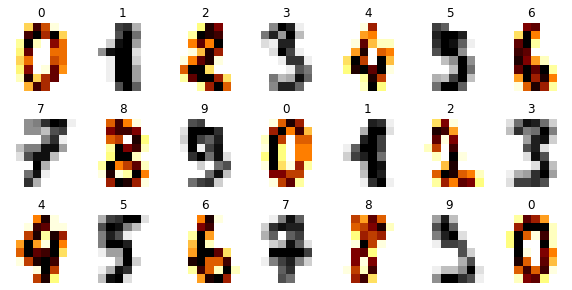

In [345]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [346]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [347]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [348]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [349]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [350]:
lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]))

array([0.58661758, 0.40131234])

In [351]:
lr_clf.fit(X_train, y_train)

In [352]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [353]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [354]:
model = CustomLogisticRegression()

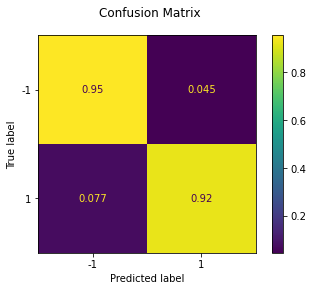

In [355]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [356]:
train_acc, test_acc

(0.9116214335421016, 0.9388888888888889)

In [357]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

<AxesSubplot:>

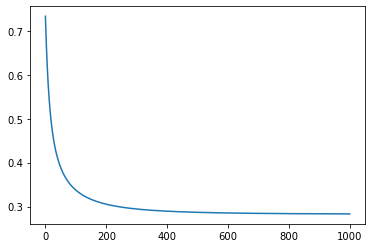

In [358]:
sns.lineplot(data=model.losss)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

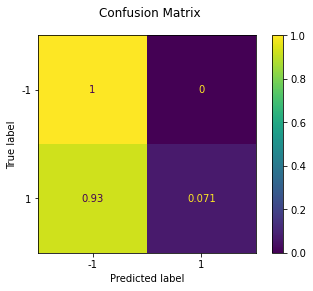

In [359]:
model = CustomLogisticRegression(eta = 0.1)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

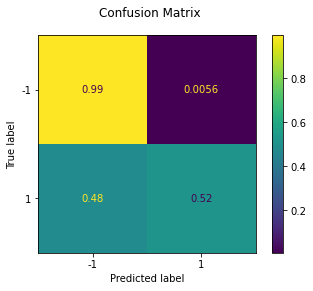

In [360]:
model = CustomLogisticRegression(eta = 0.01)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

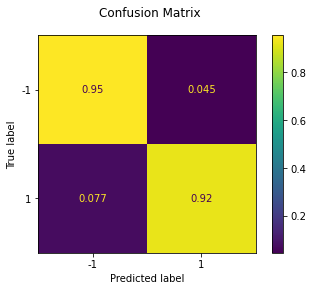

In [361]:
model = CustomLogisticRegression(eta = 0.001)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

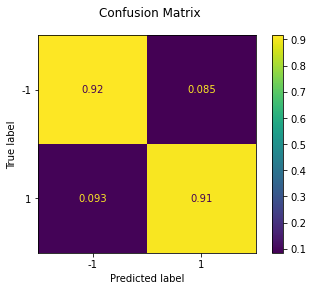

In [362]:
model = CustomLogisticRegression(eta = 0.0001)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

чем меньше скорост обучения, тем больше модели предсказывает -1, а чем больше скорость обучения, тем больше модель предсказывает 1, и нам нужно находить баланс скорости обучения.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

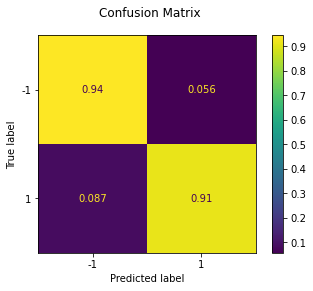

In [363]:
model = CustomLogisticRegression(C = 0.5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

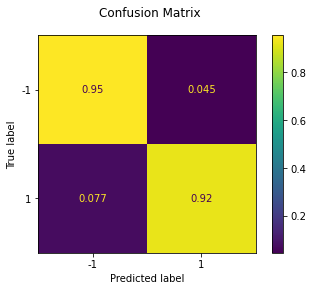

In [364]:
model = CustomLogisticRegression(C = 1)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

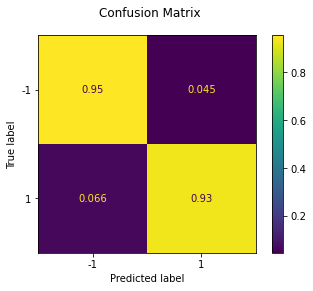

In [365]:
model = CustomLogisticRegression(C = 5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

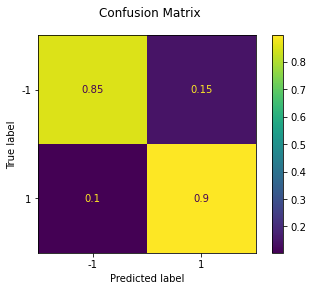

In [366]:
model = CustomLogisticRegression(C = 0.01)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

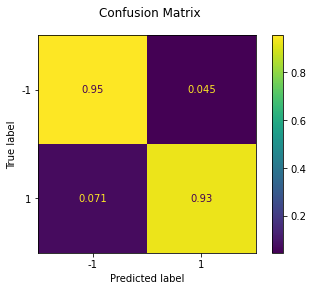

In [367]:
model = CustomLogisticRegression(C = 100)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

Чем больше параметр регурялизации, тем лучше результат, но и тем больше время обучения

**(0.5 points)** Compare zero initialization and random initialization. 

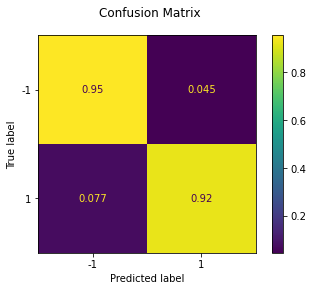

In [28]:
model = CustomLogisticRegression(zero_init = False)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

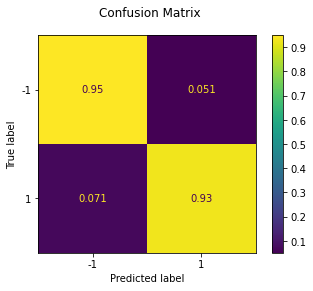

In [29]:
model = CustomLogisticRegression(zero_init = True)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [563]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = []
        for i in range(X.shape[0]):
            P.append([])
            for j in range(Y.shape[0]):
                P[i].append(sum((X[i] - Y[j]) ** 2) ** 0.5)
        return np.array(P)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = []
        weights = pd.Series(weights)
        for i in self.classes_:
            p.append(sum(weights[y == i]))
        return pd.Series(p)
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            uk = []
            for i, st in enumerate(weights_of_points):
                index_k_neighbors = pd.Series(st).sort_values(ascending=False)[:self.n_neighbors].index.tolist()
                value_k_neighbors = pd.Series(st).sort_values(ascending=False)[:self.n_neighbors].values.tolist()
                class_weights = self.get_class_weights(self.y[index_k_neighbors], value_k_neighbors)
                uk.append(class_weights/np.sum(class_weights))
            return uk
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        classes_y = self.predict_proba(X)
        answer = []
        for i in classes_y:
            answer.append(list(i).index(max(i.values.tolist())))
        return answer

In [564]:
#return KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights).fit(self.points, list(map(str, self.y))).predict_proba(X) 

In [565]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [566]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [567]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

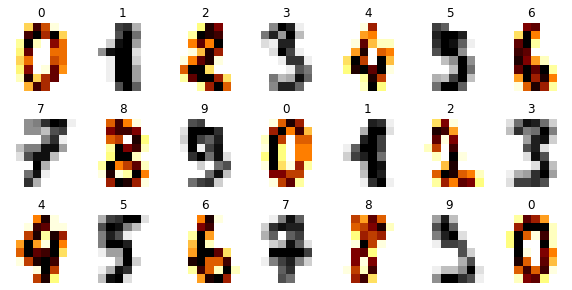

In [568]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [569]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [570]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

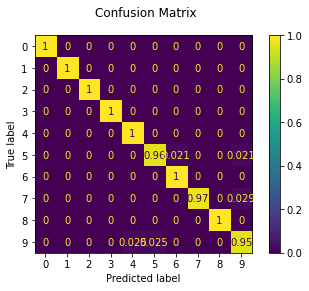

In [571]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [575]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

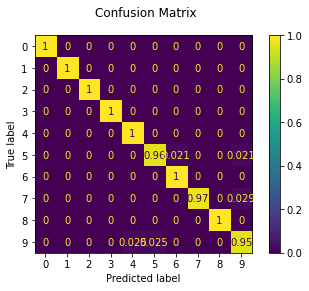

In [377]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

модель путает между собой 4 и 9, 5 и 9, 9 и 7, 6 и 5, 9 и 5. Я думаю это происходит из за того, что написание этих цифр между собой очень похоже.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

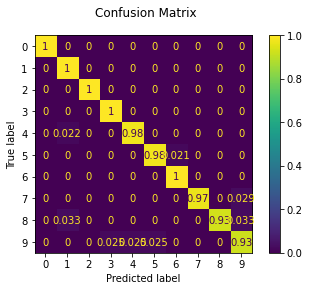

(1.0, 0.9777777777777777)

In [378]:
model = CustomKNeighborsClassifier(n_neighbors=1, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

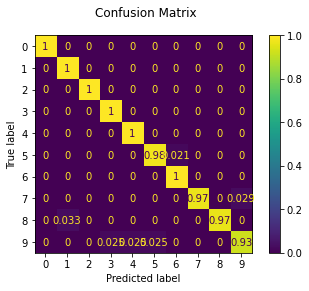

(1.0, 0.9833333333333333)

In [379]:
model = CustomKNeighborsClassifier(n_neighbors=3, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

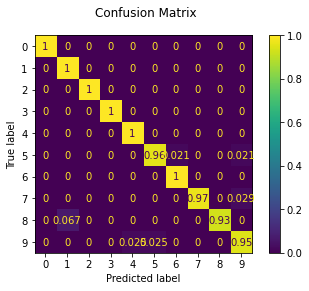

(1.0, 0.9805555555555555)

In [380]:
model = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

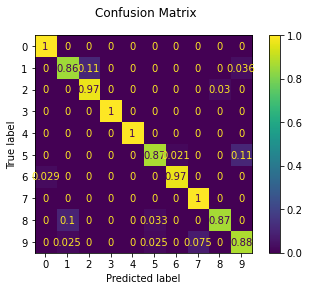

(1.0, 0.9416666666666667)

In [381]:
model = CustomKNeighborsClassifier(n_neighbors=100, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

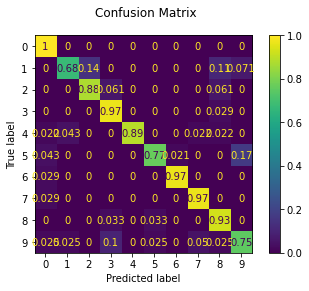

(1.0, 0.8777777777777778)

In [382]:
model = CustomKNeighborsClassifier(n_neighbors=1000, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

чем больше k_соседей, тем более устойчива модель, но и модели становится сложнее класифицировать похожие обьекты, в данном случае цифры. Но и чем меньше k_соседей, тем более неустойчива модель

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

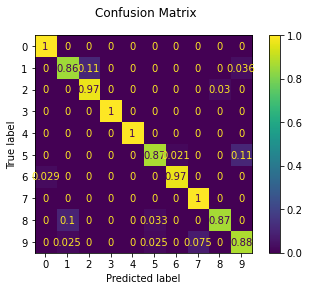

(1.0, 0.9416666666666667)

In [384]:
model = CustomKNeighborsClassifier(n_neighbors=100, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

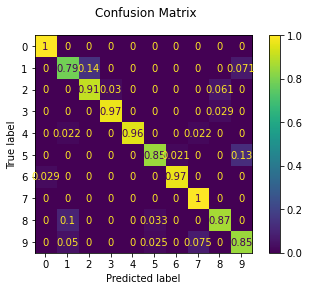

(0.9220598469032707, 0.9166666666666666)

In [383]:
model = CustomKNeighborsClassifier(n_neighbors=100, weights='uniform')
fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

в данном случае лучше использовать distance, но uniform можно использовать  когда нам не важно насколь близко находятся элементы.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

евклидова дистанция в квадрате

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Когда надо определить кошка или собака изображены на картинке, брать и проводить линию от высоко коррелируемой точки с ответом к соседним и сравнивать все точки через которые проведена линия с другими

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [578]:
PATH = "C:\\data\\"

In [579]:
data = pd.read_csv(os.path.join(PATH,  'train.csv')).set_index('PassengerId')

In [580]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'выживание по полам')

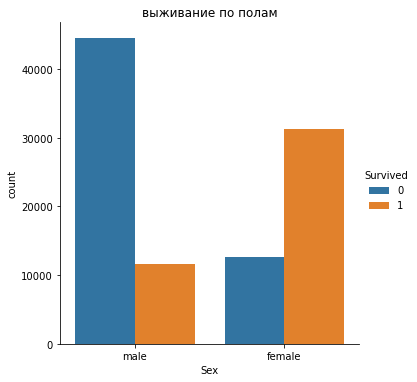

In [581]:
sns.catplot('Sex', data=data, hue="Survived", kind = 'count')
plt.title('выживание по полам')

Зависимость между выживанием и полом есть

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'возраст'}, xlabel='Age', ylabel='Density'>

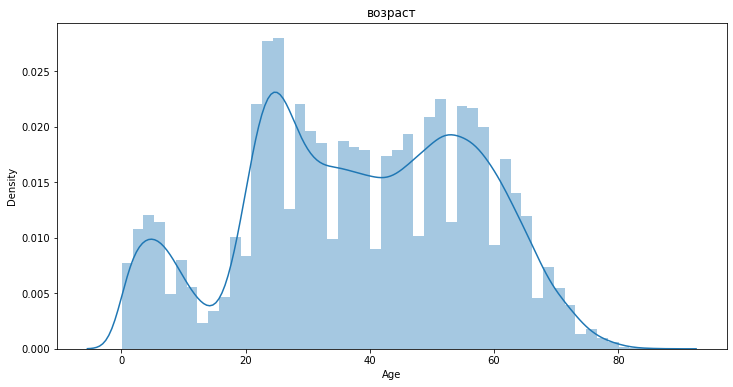

In [582]:
plt.figure(figsize=(12,6))
plt.title('возраст')
sns.distplot(a=data['Age'], kde=True)

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'возраст'}, xlabel='Age', ylabel='Density'>

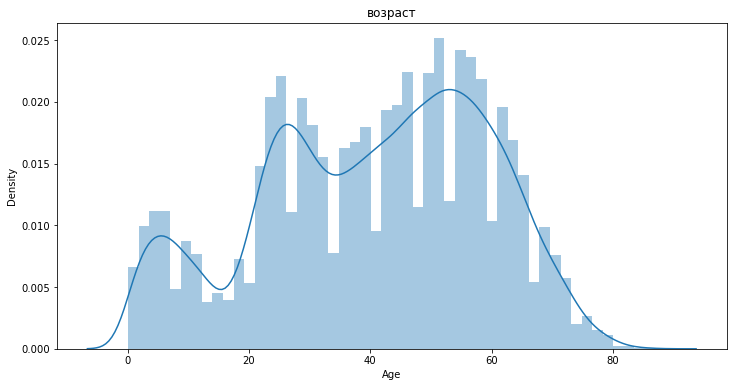

In [583]:
plt.figure(figsize=(12,6))
plt.title('возраст')
sns.distplot(a=data.loc[data['Survived'] == 1, 'Age'], kde=True)

In [584]:
np.mean(data.loc[data["Survived"] == 1, 'Age'])

40.55379931430776

In [585]:
np.median(data.loc[data["Survived"] == 1, 'Age'].fillna(0))

42.0

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'возраст'}, xlabel='Age', ylabel='Density'>

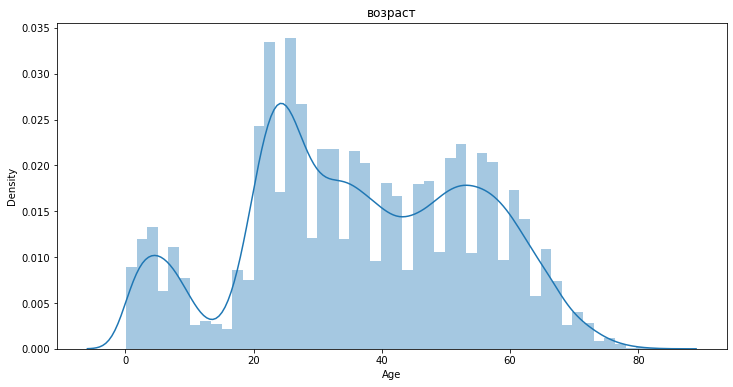

In [586]:
plt.figure(figsize=(12,6))
plt.title('возраст')
sns.distplot(a=data.loc[data['Survived'] == 0, 'Age'], kde=True)

In [587]:
np.mean(data.loc[data["Survived"] == 0, 'Age'])

36.708694881533724

In [588]:
np.median(data.loc[data["Survived"] == 0, 'Age'].fillna(0))

35.0

< your thoughts >

Разница между распределениями возраста выживших и умерших пассажиров есть, пользуясь стороними источниками и историей, предположу, что т.к. женщин и детей спасали первыми, их больше и выжило.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Выживание по классам')

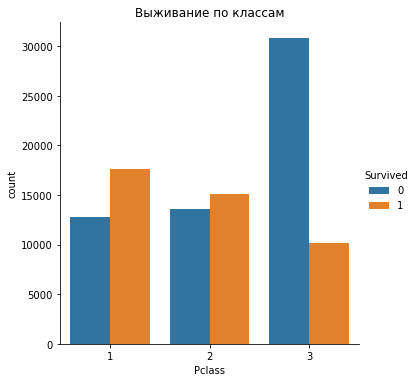

In [589]:
sns.catplot('Pclass', data=data, hue="Survived", kind = 'count')
plt.title('Выживание по классам')

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Выживание по классам')

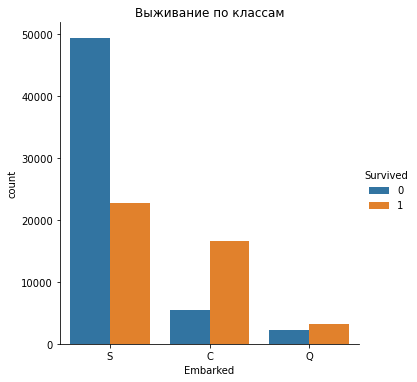

In [590]:
sns.catplot('Embarked', data=data, hue="Survived", kind = 'count')
plt.title('Выживание по классам')

< your thoughts >

зависимость между местом посадки и выживанием есть

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [591]:
for i in data.columns:
    print(i, ' : ', str(int((data[i].isna().sum() / data[i].shape) * 100)) + '%')

Survived  :  0%
Pclass  :  0%
Name  :  0%
Sex  :  0%
Age  :  3%
SibSp  :  0%
Parch  :  0%
Ticket  :  4%
Fare  :  0%
Cabin  :  67%
Embarked  :  0%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

можно просто не учитывать колонки с большим процентом пропущенных значений

Преемущества:

    *не надо заменять пропущенные значение, что делает модель более точной*
Недостатки:

    *столбец который мы не учитываем может иметь большую корреляцию с y*

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [592]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
log_reg = LogisticRegression()
knn = KNeighborsClassifier()

In [593]:
X = data[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']]
y = data['Survived']
X.loc[X['Sex'] == 'male', 'Sex'] = 0
X.loc[X['Sex'] == 'female', 'Sex'] = 1
X['Age'] = X['Age'].fillna(np.mean(X['Age']))
X.loc[X['Embarked'] == 'S', 'Embarked'] = 0
X.loc[X['Embarked'] == 'C', 'Embarked'] = 1
X.loc[X['Embarked'] == 'Q', 'Embarked'] = 2
X['Fare'] = X['Fare'].fillna(np.mean(X['Fare']))
X['Embarked'] = X['Embarked'].fillna('0')
sca = StandardScaler()
X = sca.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

C:\Users\Alexander\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-593-09d8fe606aa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = X['Age'].fillna(np.mean(X['Age']))
<ipython-input-593-09d8fe606aa4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [594]:
re = cross_validate(log_reg, X, y, cv=5)
print(re['test_score'])

[0.75555 0.7627  0.7587  0.75615 0.75865]


In [595]:
re = cross_validate(knn, X, y, cv=5)
print(re['test_score'])

[0.74095 0.7401  0.73975 0.73815 0.7402 ]


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [5]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'tol':[5, 4, 3, 2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'C':[100000, 90000, 80000, 70000, 60000, 50000, 40000, 30000, 20000, 10000], 
#              'max_iter':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60]}
#clf = GridSearchCV(log_reg, parameters)
#clf.fit(X_train, y_train)

In [164]:
clf.best_params_

{'C': 100000, 'max_iter': 7, 'tol': 3}

In [165]:
clf.best_score_

0.7642537313432836

In [4]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brut'], 'weights':['uniform', 'distance']}
#clf = GridSearchCV(knn, parameters)
#clf.fit(X_train, y_train)

In [597]:
clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}

In [598]:
clf.best_score_

0.7525373134328358

In [387]:
data = pd.read_csv(os.path.join(PATH,  'train.csv')).set_index('PassengerId')

<AxesSubplot:>

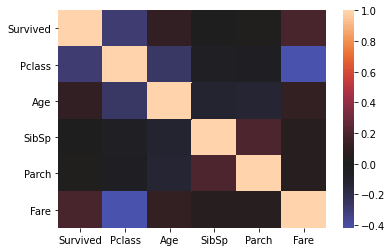

In [391]:
sns.heatmap(data.corr(), center = 0)

In [260]:
X = data[['Sex', 'Age', 'Parch', 'Fare', 'Embarked']]

In [261]:
X['Embarked_S'] = 0
X.loc[X['Embarked'] == 'S', 'Embarked_S'] = 1
X['Embarked_C'] = 0
X.loc[X['Embarked'] == 'C', 'Embarked_C'] = 1
X['Embarked_Q'] = 0
X.loc[X['Embarked'] == 'Q', 'Embarked_Q'] = 1
X['Sex_male'] = 0
X.loc[X['Sex'] == 'male', 'Sex_male'] = 1
X['Sex_female'] = 0
X.loc[X['Sex'] == 'female', 'Sex_female'] = 1
X = X.drop(columns=['Embarked', 'Sex'])
X['Fare'] = X['Fare'].fillna(np.mean(X['Fare']))
X['Age'] = X['Age'].fillna(np.mean(X['Age']))
X = sca.fit_transform(X, y)
y = data['Survived']

<ipython-input-261-d45e12db76f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Embarked_S'] = 0
C:\Users\Alexander\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-261-d45e12db76f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [3]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'tol':[0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5], 'C':[1, 2, 3, 100000], 
#              'max_iter':[1, 2, 3, 4], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty':['l1', 'l2', 'elasticnet', 'none'],
#             'multi_class': ['auto', 'ovr', 'multinomial']} 
#clf = GridSearchCV(log_reg, parameters)
#clf.fit(X, y)

In [265]:
log_reg = LogisticRegression(C = 2, max_iter = 2, penalty = "l1", solver = "saga", tol = 0.0001, multi_class = 'ovr')

In [266]:
log_reg.fit(X, y)

C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=2, max_iter=2, multi_class='ovr', penalty='l1',
                   solver='saga')

In [267]:
data = pd.read_csv(os.path.join(PATH,  'test.csv')).set_index('PassengerId')

In [268]:
X = data[['Sex', 'Age', 'Parch', 'Fare', 'Embarked']]

In [269]:
X['Embarked_S'] = 0
X.loc[X['Embarked'] == 'S', 'Embarked_S'] = 1
X['Embarked_C'] = 0
X.loc[X['Embarked'] == 'C', 'Embarked_C'] = 1
X['Embarked_Q'] = 0
X.loc[X['Embarked'] == 'Q', 'Embarked_Q'] = 1
X['Sex_male'] = 0
X.loc[X['Sex'] == 'male', 'Sex_male'] = 1
X['Sex_female'] = 0
X.loc[X['Sex'] == 'female', 'Sex_female'] = 1
X['Fare'] = X['Fare'].fillna(np.mean(X['Fare']))
X['Age'] = X['Age'].fillna(np.mean(X['Age']))
X = X.drop(columns=['Embarked', 'Sex'])
X = sca.transform(X)

<ipython-input-269-05c150c5f7c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Embarked_S'] = 0
C:\Users\Alexander\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-269-05c150c5f7c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [270]:
z = log_reg.predict(X).tolist()

In [272]:
t = [0] * len(z)
for i in range(len(z)):
    t[i] = 100000+i
pred = pd.DataFrame([t, z], index=['PassengerId', 'Survived']).T

In [274]:
pred.to_csv('pred19.csv')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

## score 0.8 проверить можно в репозитории p.s. я оставил там скрин